In [1]:
import copy

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from alns import ALNS, State
from alns.criteria import HillClimbing

In [2]:
%matplotlib inline

In [3]:
SEED = 5432

# The cutting-stock problem

The [cutting-stock problem (CSP)](https://en.wikipedia.org/wiki/Cutting_stock_problem) is well-known problem in operations research. In simple terms, it asks how many pieces of material are needed to cut an ordered amount of differently-sized beams, such that the wastage is minimised. Many different formulations exist, e.g. for the one-, two-, and even three-dimensional case. Here we solve an instance of the one-dimensional problem, obtained from the data [here](http://www.math.tu-dresden.de/~capad/cpd-ti.html#1D). It is known that the optimal solution for this problem requires the use of only 74 beams.

In [4]:
OPTIMAL_BEAMS = 74

In [5]:
# The first line lists the number of lines for beam orders.
# The second line is the length of the available beams. Each
# following line is an order of (length, amount) tuples.
with open('640.csp') as file:
    data = file.readlines()

NUM_LINES = int(data[0])
BEAM_LENGTH = int(data[1])

# Beams to be cut from the available beams
BEAMS = [int(length)
         for datum in data[-NUM_LINES:]
         for length, amount in [datum.strip().split()]
         for _ in range(int(amount))]

print("Each available beam is of length:", BEAM_LENGTH)
print("Number of beams to be cut (orders):", len(BEAMS))

Each available beam is of length: 1000
Number of beams to be cut (orders): 180


## Operators and solution state

To use the ALNS meta-heuristic, we need to have destroy and repair operators that work on a proposed solution, and a way to describe such a solution in the first place. The ALNS package exposes the class ``State`` to describe a solution, with an ``objective()`` member that computes this solution's objective value. Using it, we may compute a simple initial solution, and then apply the ALNS algorithm.

## Solution state

In [6]:
class CspState(State):
    """
    Solution state for the CSP problem. It has two data members, assignments
    and unassigned. Assignments is a list of lists, one for each beam in use.
    Each entry is another list, containing the ordered beams cut from this 
    beam. Each such sublist must sum to at most BEAM_LENGTH. Unassigned is a
    list of ordered beams that are not currently assigned to one of the
    available beams.
    """

    def __init__(self, assignments, unassigned=None):
        self.assignments = assignments
        self.unassigned = []
        
        if unassigned is not None:
            self.unassigned = unassigned

    def copy(self):
        """
        Helper method to ensure each solution state is immutable.
        """
        return CspState(copy.deepcopy(self.assignments),
                        self.unassigned.copy())

    def objective(self):
        """
        Computes the total number of beams in use.
        """
        return len(self.assignments)

    def plot(self):
        """
        Helper method to plot a solution.
        """
        _, ax = plt.subplots(figsize=(12, 6))

        ax.barh(np.arange(len(self.assignments)), 
                [sum(assignment) for assignment in self.assignments], 
                height=1)

        ax.set_xlim(right=BEAM_LENGTH)
        ax.set_yticks(np.arange(len(self.assignments), step=10))

        ax.margins(x=0, y=0)

        ax.set_xlabel('Usage')
        ax.set_ylabel('Beam (#)')

        plt.draw_if_interactive()

In [7]:
def wastage(assignment):
    """
    Helper method that computes the wastage on a given beam assignment.
    """
    return BEAM_LENGTH - sum(assignment)

# Destroy operators

We will consider two simple destroy operators, **random_removal** and **worst_removal**. Random removal randomly removes currently assigned beams, whereas worst removal removes those beams that are currently cut with the most waste. Both remove a fixed percentage of the current solution state, controlled by a degree of destruction parameter.

In [8]:
degree_of_destruction = 0.25

def beams_to_remove(num_beams):
    return int(num_beams * degree_of_destruction)

In [9]:
def random_removal(state, random_state):
    """
    Iteratively removes randomly chosen beam assignments.
    """
    state = state.copy()

    for _ in range(beams_to_remove(state.objective())):
        idx = random_state.randint(state.objective())
        state.unassigned.extend(state.assignments.pop(idx))

    return state

In [10]:
def worst_removal(state, random_state):
    """
    Removes beams in decreasing order of wastage, such that the
    poorest assignments are removed first.
    """
    state = state.copy()

    # Sort assignments by wastage, worst first
    state.assignments.sort(key=wastage, reverse=True)

    # Removes the worst assignments
    for _ in range(beams_to_remove(state.objective())):
        state.unassigned.extend(state.assignments.pop(0))

    return state

# Repair operators

We define two equally simple repair operators, **greedy_insert** and **minimal_wastage**. The first considers each currently unassigned ordered beam, and finds the first beam this order may be inserted into. The second does something similar, but finds a beam where its insertion would result in the smallest beam wastage.

In [11]:
def greedy_insert(state, random_state):
    """
    Inserts the unassigned beams greedily into the first fitting
    beam. Shuffles the unassigned ordered beams before inserting.
    """
    random_state.shuffle(state.unassigned)

    while len(state.unassigned) != 0:
        beam = state.unassigned.pop(0)

        for assignment in state.assignments:
            if beam <= wastage(assignment):
                assignment.append(beam)
                break
        else:
            state.assignments.append([beam])

    return state

In [12]:
def minimal_wastage(state, random_state):
    """
    For every unassigned ordered beam, the operator determines
    which beam would minimise that beam's waste once the ordered
    beam is inserted.
    """
    def insertion_cost(assignment, beam):  # helper method for min
        if beam <= wastage(assignment):
            return wastage(assignment) - beam

        return float("inf")

    while len(state.unassigned) != 0:
        beam = state.unassigned.pop(0)

        assignment = min(state.assignments,
                         key=partial(insertion_cost, beam=beam))

        if beam <= wastage(assignment):
            assignment.append(beam) 
        else:
            state.assignments.append([beam])

    return state

# Initial solution

In [13]:
rnd_state = rnd.RandomState(SEED)

state = CspState([], BEAMS.copy())
initial_solution = greedy_insert(state, rnd_state)

print("Initial solution has objective value:", initial_solution.objective())

Initial solution has objective value: 81


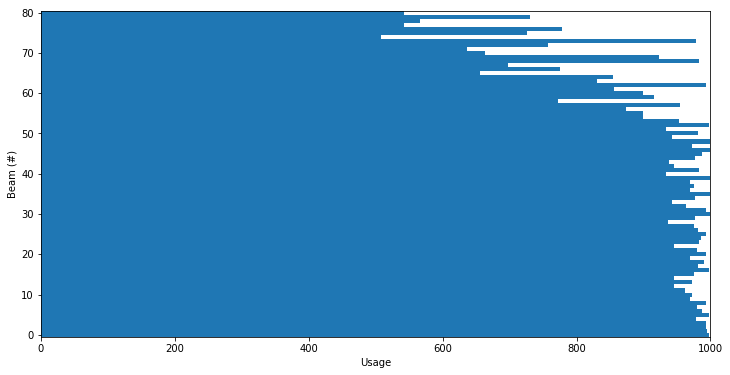

In [14]:
initial_solution.plot()

# Heuristic solution

In [15]:
alns = ALNS(rnd_state)

alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(worst_removal)

alns.add_repair_operator(greedy_insert)
alns.add_repair_operator(minimal_wastage)

In [16]:
criterion = HillClimbing()

result = alns.iterate(initial_solution, [3, 2, 1, 0.5], 0.8, criterion,
                      iterations=5000, collect_stats=True)

solution = result.best_state

objective = solution.objective()

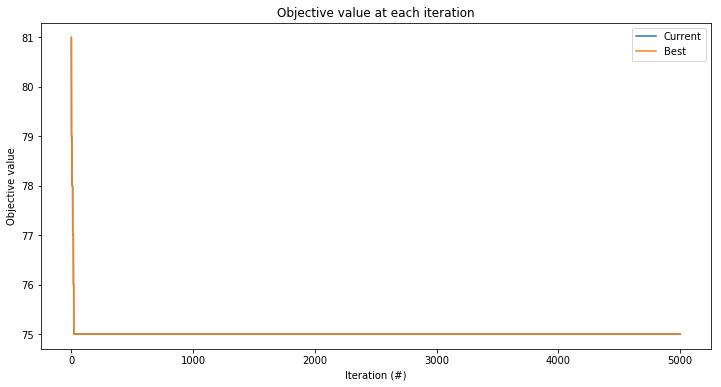

In [17]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

Having obtained a reasonable solution, we now want to investigate each operator's performance. This may be done via the `plot_operator_counts()` method on the `result` object, like below. 

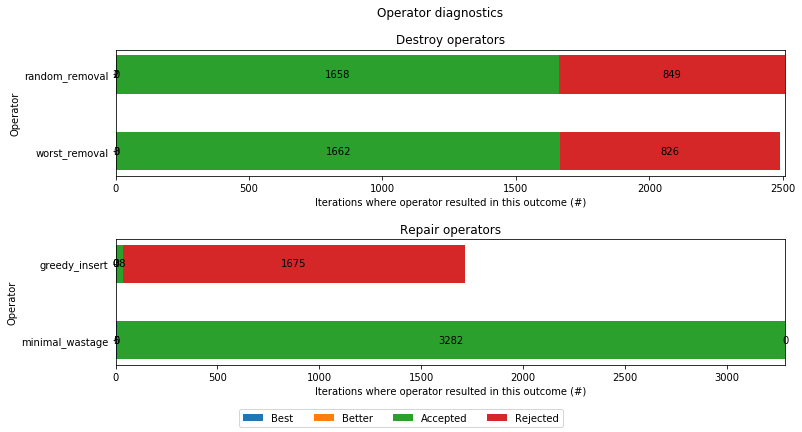

In [18]:
figure = plt.figure("operator_counts", figsize=(12, 6))
figure.subplots_adjust(bottom=0.15, hspace=.5)
result.plot_operator_counts(figure=figure, title="Operator diagnostics")

Several conclusions follow,

* The destroy operators are about equally good, so there is little to be gained changing these around.
* The repair operators, however, are not created equal: the `minimal_wastage` operator is significantly better than the simple `greedy_insert`. This makes intuitive sense, as minimising wastage exploits the assignment structure much better than a simple insertion heuristic does. It follows that the `greedy_insert` operator is actually not all that useful, and may be dropped from the ALNS heuristic altogether.

In [19]:
print("Heuristic solution has objective value:", solution.objective())

Heuristic solution has objective value: 75


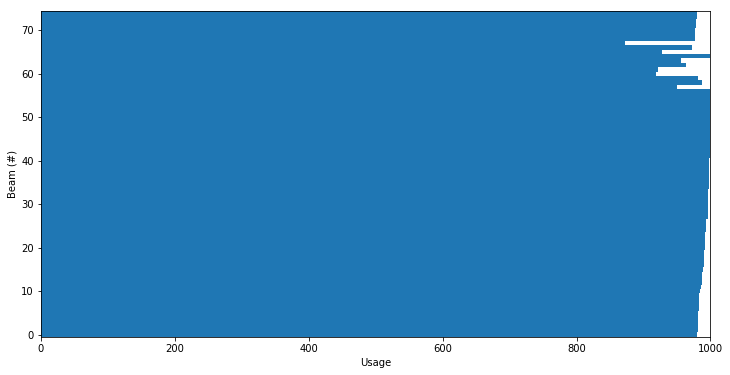

In [20]:
solution.plot()

In [21]:
print("Number of beams used is {0}, which is {1} more than the optimal value, which was {2}."
      .format(solution.objective(), solution.objective() - OPTIMAL_BEAMS, OPTIMAL_BEAMS))

Number of beams used is 75, which is 1 more than the optimal value, which was 74.


# Conclusions

In the code above we implement a simple ALNS-based heuristic for the CSP. Although the operators are simple and few, we do find very good results in limited time: we require just one more beam than optimal solution does, a result that is **1.35%** above optimal.

This notebook offers another case where the ALNS library may be put to use to construct powerful, efficient heuristic pipelines from simple, locally greedy operators.